# LSTM to predict Amazon Stock Price by December 31 2020

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense
import math
from sklearn.metrics import mean_squared_error

In [119]:
#the AMZN.csv file contains the stock prices of AMAZON from the last 5 years. 
#This data was downloaded from Yahoo Finance website
directory = './Desktop/AMZN.csv'
dataset = pd.read_csv(directory)

In [125]:
#get a preview of the dataset
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500
1,2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600
2,2016-01-06,622.000000,639.789978,620.309998,632.650024,632.650024,5329200
3,2016-01-07,621.799988,630.000000,605.210022,607.940002,607.940002,7074900
4,2016-01-08,619.659973,624.140015,606.000000,607.049988,607.049988,5512900


Text(0, 0.5, 'stock price at closing')

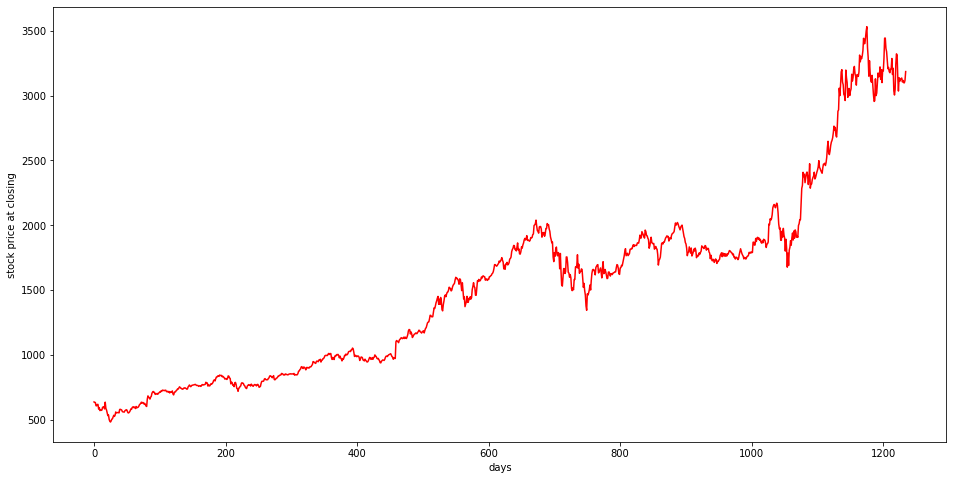

In [129]:
#plot values from the 'Close' columns to get an idea of how the stock Price has been changing.
#Note that we will only use the 'Close' column values for our prediction
plt.figure(figsize=(16, 8))
plt.plot(dataset.Close, "r-")
plt.xlabel('days')
plt.ylabel('stock price at closing')

Data Preprocessing

In [130]:
# get the values from "Close" column that will use for the prediction
x = dataset.reset_index()['Close']

In [55]:
#normalizing our data use MinMaxSacaler.
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(np.array(x).reshape(-1,1))

In [131]:
# divide data into TRain/Val Split
s= int((len(x_scaled)*0.7))
s2 = len(x_scaled)
x_train = x_scaled[:s]
x_val= x_scaled[s:s2]

In [69]:
#Since 
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [171]:
#create a test data with a time steps of 30 days (one month)
time_step = 183
X_train, Y_train = create_dataset(x_train, time_step)
X_val, Y_val = create_dataset(x_val, time_step)

In [172]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

                        Build a simple stacked LSTM Model, Compile it and train the model

In [173]:
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape = (183, 1)))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

In [174]:
model.compile(loss="mean_squared_error", optimizer = "adam")

In [175]:
model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size = 32, epochs = 100 )

Epoch 1/100
22/22 [==============================] - 6s 259ms/step - loss: 0.0111 - val_loss: 0.0377
Epoch 2/100
22/22 [==============================] - 5s 229ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 3/100
22/22 [==============================] - 5s 242ms/step - loss: 5.5404e-04 - val_loss: 0.0050
Epoch 4/100
22/22 [==============================] - 6s 253ms/step - loss: 5.1838e-04 - val_loss: 0.0066
Epoch 5/100
22/22 [==============================] - 6s 275ms/step - loss: 5.0586e-04 - val_loss: 0.0073
Epoch 6/100
22/22 [==============================] - 6s 268ms/step - loss: 4.4823e-04 - val_loss: 0.0045
Epoch 7/100
22/22 [==============================] - 6s 271ms/step - loss: 4.7228e-04 - val_loss: 0.0052
Epoch 8/100
22/22 [==============================] - 6s 275ms/step - loss: 4.2884e-04 - val_loss: 0.0061
Epoch 9/100
22/22 [==============================] - 6s 281ms/step - loss: 4.5674e-04 - val_loss: 0.0059
Epoch 10/100
22/22 [==============================] - 6s 284ms/

In [176]:
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)

In [177]:
train_predict1 = scaler.inverse_transform(train_predict)
val_predict1 = scaler.inverse_transform(val_predict)

In [178]:
train_score = math.sqrt(mean_squared_error(Y_train, train_predict1))
val_score = math.sqrt(mean_squared_error(Y_val, val_predict1))

In [179]:
print (train_score, val_score)

1360.464490160662 2486.194535739303


                    Predit the Stock Price for the next 100 days given values of the 30 days

In [190]:
#take values of the last 6 months from the dataset. This will be used as our input dataset to predict the next 35 days
my_input = x_val[187:].reshape(1,-1)

In [191]:
temp_input=list(my_input)
temp_input=temp_input[0].tolist()
print (len(temp_input))

184


In [192]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=183
i=0
while(i<36):
    
    if(len(temp_input)>30):
        my_input=np.array(temp_input[1:])
        my_input=my_input.reshape(1,-1)
        my_input = my_input.reshape((1, n_steps, 1))
        yhat = model.predict(my_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        my_input = my_input.reshape((1, n_steps,1))
        yhat = model.predict(my_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(len(lst_output))

36


In [193]:
day_new=np.arange(1,184)
day_pred=np.arange(184,220)

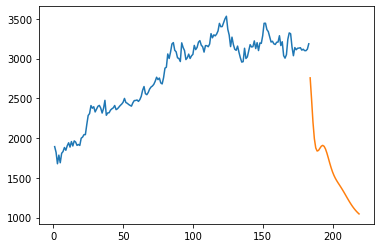

In [197]:
plt.plot(day_new,scaler.inverse_transform(x_scaled[1052:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))